In [1]:
import os
import time
import random
import numpy as np

import tensorflow as tf
import tensorflow.contrib.layers as layers

import gym
from gym import spaces
from PIL import Image
from collections import deque, namedtuple
from IPython.display import HTML
from IPython import display
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

/root/miniconda3/envs/tf/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
from environments import Snake
from visual_utils import AgentViz
from methods import DistQNetwork, QNetwork, ReplayMemory

In [3]:
def plot_average(r, eta):
    ret = np.cumsum(r, dtype=np.float)
    ret[eta:] = ret[eta:] - ret[:-eta] 
    y = ret[eta - 1:] / eta
    return y

def plot_performance(path, eta=10, x_scale=100000):
    r_train = np.load(path + "/learning_curve.npz")["r"]
    f_train = np.load(path + "/learning_curve.npz")["f"]/x_scale
    x = plot_average(f_train, eta)
    y = plot_average(r_train, eta)
    plt.plot(x, y)
    plt.grid()
    
def plot_compare(paths, eta, x_scale=100000):
    
    r, f = [], []
    for i in range(len(paths)):
        r = np.load(paths[i] + "/learning_curve.npz")["r"]
        f = np.load(paths[i] + "/learning_curve.npz")["f"]/x_scale
        x = plot_average(f, eta)
        y = plot_average(r, eta)
        plt.plot(x, y)
    plt.grid()

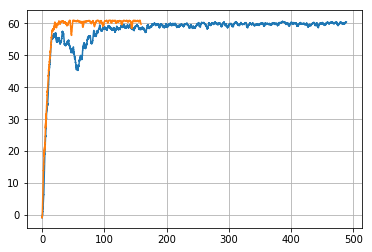

In [248]:
path0 = 'snake_models/dqn/boltzmann_8x8e999_5d_stupid'
path1 = 'snake_models/test3'
plot_compare([path0, path1], eta=300)

In [4]:
def plot_means_and_stdevs(x, y, tau, figsize=(8, 5), color='dodgerblue'):
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    means = np.cumsum(y, dtype=np.float)
    stdevs = np.cumsum(np.square(y), dtype=np.float)
    
    means[tau:] = means[tau:] - means[:-tau]
    means = means[tau-1:] / tau
    
    stdevs[tau:] = stdevs[tau:] - stdevs[:-tau]
    stdevs = stdevs[tau-1:] / tau - np.square(means)
    stdevs = np.sqrt(stdevs)
    
    lower = means - stdevs
    upper = means + stdevs
    
    x = plot_average(x, tau)
    
    ax.plot(x, means, color=color)
    ax.fill_between(x, lower, means, alpha=0.2, where=lower <= means, facecolor=color)
    ax.fill_between(x, upper, means, alpha=0.2, where=upper >= means, facecolor=color)
    
    ax.grid()
    
def plot_learning_curve(path, tau=100, figsize=(8, 5), x_scale=100000, color='dodgerblue'):
    r = np.load(path+"/learning_curve.npz")['r']
    f_train = np.load(path + "/learning_curve.npz")["f"]/x_scale
    
    plot_means_and_stdevs(f_train, r, tau=tau, figsize=figsize, color=color)
    
    
def plot_reward_distribution(path, from_episode=0, num_episodes=100, bins=None):
    r = np.load(path+"/learning_curve.npz")['r']
    plt.hist(r[from_episode:from_episode+num_episodes], bins=bins,
             color='dodgerblue', edgecolor='black', linewidth=1.5)
    plt.grid()
    
def compare_two_distributions(path, from_episode1=0, from_episode2=100, 
                              num_episodes=100, bins=None):
    r = np.load(path+"/learning_curve.npz")['r']
    
    hist1 = r[from_episode1:from_episode1+num_episodes]
    hist2 = r[from_episode2:from_episode2+num_episodes]
    hist12 = np.concatenate((hist1, hist2))
    
    left = np.min(hist12)
    right = np.max(hist12)
    
    plt.hist(hist1, bins=bins, range=[left, right], color='dodgerblue', 
             edgecolor='black', linewidth=1.5, alpha=0.7)
    plt.hist(hist2, bins=bins, range=[left, right],color='mediumseagreen', 
             edgecolor='black', linewidth=1.5, alpha=0.7)
    plt.grid()
    
    
    
def compare_two_distributions_animated(path, from_episode1=0, from_episode2=100, 
                                       num_episodes=100, bins=None):
    r = np.load(path+"/learning_curve.npz")['r']
    
    hist1 = r[from_episode1:from_episode1+num_episodes]
    hist2 = r[from_episode2:from_episode2+num_episodes]
    hist12 = np.concatenate((hist1, hist2))
    
    left = np.min(hist12)
    right = np.max(hist12)
    
    ax = plt.gca()
    
    for i in range((len(r) - from_episode2) // num_episodes):
        hist2 = r[from_episode2 + i * num_episodes:from_episode2+(i + 1) * num_episodes]
        hist12 = np.concatenate((hist1, hist2))
        left = np.min(hist12)
        right = np.max(hist12)
    
        ax.cla()
        ax.hist(hist1, bins=bins, range=[left, right], color='dodgerblue', 
             edgecolor='black', linewidth=1.5, alpha=0.7)
        ax.hist(hist2, bins=bins, range=[left, right],color='mediumseagreen', 
             edgecolor='black', linewidth=1.5, alpha=0.7)
        
        #plt.pause(1e-17)
        plt.draw()
    #plt.grid()
    
    
def plot_lifetimes(path, eta=10, x_scale=100000):
    l_train = np.load(path + "/learning_curve.npz")["l"]
    f_train = np.load(path + "/learning_curve.npz")["f"]/x_scale
    x = plot_average(f_train, eta)
    y = plot_average(l_train, eta)
    plt.plot(x, y)
    plt.grid()

In [13]:
path = 'snake_models/test-gauss-boi-l2-3sigma'
r = np.load(path + "/learning_curve.npz")['r']

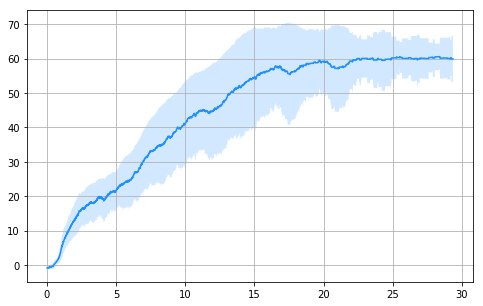

In [14]:
plot_learning_curve(path, tau=200)
#plt.ylim([0, 97]);

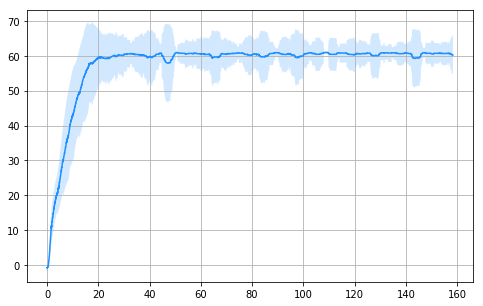

In [17]:
plot_learning_curve('snake_models/test3', tau=500)

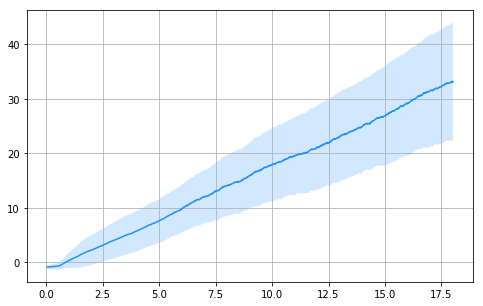

In [29]:
plot_learning_curve('snake_models/test-big', tau=500)

In [30]:
path = 'atari_models/test'
r = np.load(path + "/learning_curve.npz")['r']

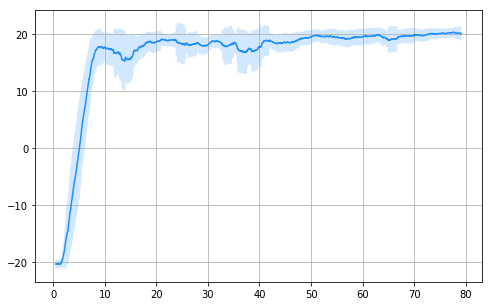

In [31]:
plot_learning_curve(path, tau=100)

In [41]:
path = 'snake_models/test-gauss-boi-l2-3sigma/'
r = np.load(path + "/learning_curve.npz")['r']

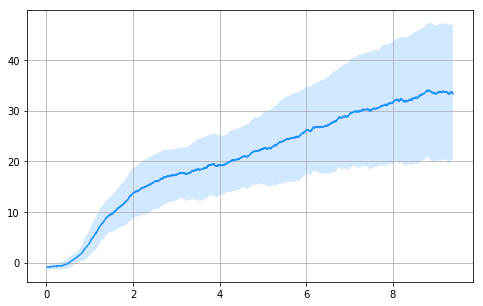

In [44]:
plot_learning_curve(path, tau=300)

In [43]:
max(r)

56